In [697]:
%pip install ipykernel numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Підготовчий етап
Провести аналіз вибраного набору даних, визначити вхідні та вихідні параметри, візуалізувати залежності входів на виходу, спробувати виявити основні залежності, детектувати аномалії, неповні зразки тощо у даних.

Дорожна карта для підготовки даних - стр. 34-35 рекомендованої книги.

In [698]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [699]:
filename = 'data/heart.csv'
data = pd.read_csv(filename)

print("Перші 5 рядків:")
display(data.head())

print("-"*60, "Інформація про дані:", sep='\n')
display(data.info())

print("-"*60, "Описова статистика:", sep='\n')
display(data.describe().T)

print("-"*60, "Пропуски в даних:", sep='\n')
print(data.isnull().sum())

Перші 5 рядків:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


------------------------------------------------------------
Інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


None

------------------------------------------------------------
Описова статистика:


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


------------------------------------------------------------
Пропуски в даних:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [700]:
data_ = pd.get_dummies(data, drop_first=True)  # one-hot encoding
X = data_.drop('HeartDisease', axis=1).to_numpy(dtype=float)
y = data_.HeartDisease.to_numpy(dtype=int)[:, None]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((642, 15), (276, 15), (642, 1), (276, 1))

In [701]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Реалізація класифікатору
Вивчити засади роботи багатошарового персептрону та основні архітектури. Написати код класифікатору для обраного набору даних.

In [702]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    s = relu(x)
    return (s > 0).astype(float)

class MultiLayerPerceptron:
    def __init__(self, input_size: int, hidden_size: list[int], output_size: int, learning_rate: float = 0.01, batch_size: int = 32, iterations: int = 1000, seed: int = 42, end_activation_function: callable = sigmoid, end_activation_function_derivative: callable = sigmoid_derivative):
        self.rng = np.random.default_rng(seed)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.iterations = iterations

        self.end_activation_function = end_activation_function
        self.end_activation_function_derivative = end_activation_function_derivative

        self.weights = []
        self.bias = []
        prev_size = input_size
        for size in hidden_size + [output_size]:
            self.weights.append(self.rng.uniform(-1, 1, (prev_size, size)))
            # limit = np.sqrt(2 / prev_size)
            # self.weights.append(self.rng.normal(0, limit, (prev_size, size)))
            # self.weights.append(np.zeros((prev_size, size)))
            # self.weights.append(np.random.randn(prev_size, size))
            self.bias.append(np.zeros(size))
            prev_size = size

        # limit = np.sqrt(6 / (prev_size + output_size))
        # self.weights.append(self.rng.uniform(-limit, limit, (prev_size, output_size)))
        # self.bias.append(np.zeros(output_size))

    def _calculate_mse(self, X: np.ndarray, y: np.ndarray):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y_pred = self.predict(X)
        return np.mean(np.square(y - y_pred))

    def _calculate_accuracy(self, X: np.ndarray, y: np.ndarray):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        y_pred = self.predict(X)
        if self.weights[-1].shape[1] == 1:
            y_pred = (y_pred > 0.5).astype(int)
        return accuracy_score(y, y_pred)
        #     return np.mean(predictions == true_values)
        # else:
        #     return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))

    def fit(self, X: np.ndarray, y: np.ndarray):
        history = {
            'loss': [],
            'accuracy': []
        }
        for iteration in range(self.iterations):
            for i in range(0, X.shape[0], self.batch_size):
                batch_x = X[i:i + self.batch_size]
                batch_y = y[i:i + self.batch_size]
                self._fit_batch(batch_x, batch_y)
            loss = self._calculate_mse(X, y)
            acc = self._calculate_accuracy(X, y)
            
            history['loss'].append(loss)
            history['accuracy'].append(acc)
            
            if iteration % 100 == 0:
                print(f"Epoch {iteration} - Loss: {loss:.4f} - Acc: {acc:.4f}")
        return history

    def _fit_batch(self, X: np.ndarray, y: np.ndarray):
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        activations = [X]
        inputs = []
        for i, (weight, bias) in enumerate(zip(self.weights, self.bias)):
            X_next = (activations[-1] @ weight) + bias
            inputs.append(X_next)

            if i == len(self.weights) - 1:
                y_ = self.end_activation_function(X_next)
            else:
                # y_ = relu(X_next)
                y_ = sigmoid(X_next)
                
            activations.append(y_)

        error = activations[-1] - y
        delta = error * self.end_activation_function_derivative(inputs[-1])

        for i in reversed(range(len(self.weights))):
            a_prev = activations[i]
            self.weights[i] -= self.learning_rate * a_prev.T @ delta
            self.bias[i] -= self.learning_rate * np.sum(delta, axis=0)

            if i != 0:
                # delta = (delta @ self.weights[i].T) * relu_derivative(inputs[i-1])
                delta = (delta @ self.weights[i].T) * sigmoid_derivative(inputs[i-1])

    def predict(self, X: np.ndarray):
        activations = [X]
        for i, (weight, bias) in enumerate(zip(self.weights, self.bias)):
            X_next = (activations[-1] @ weight) + bias
            if i == len(self.weights) - 1:
                y_ = self.end_activation_function(X_next)
            else:
                y_ = relu(X_next)
            activations.append(y_)
        return activations[-1]


Epoch 0 - Loss: 0.4157 - Acc: 0.5841
Epoch 100 - Loss: 0.4149 - Acc: 0.5841
Epoch 200 - Loss: 0.4129 - Acc: 0.5872
Epoch 300 - Loss: 0.4143 - Acc: 0.5857
Epoch 400 - Loss: 0.4143 - Acc: 0.5857
Epoch 500 - Loss: 0.4143 - Acc: 0.5857
Epoch 600 - Loss: 0.4128 - Acc: 0.5872
Epoch 700 - Loss: 0.4097 - Acc: 0.5903
Epoch 800 - Loss: 0.4143 - Acc: 0.5857
Epoch 900 - Loss: 0.4143 - Acc: 0.5857


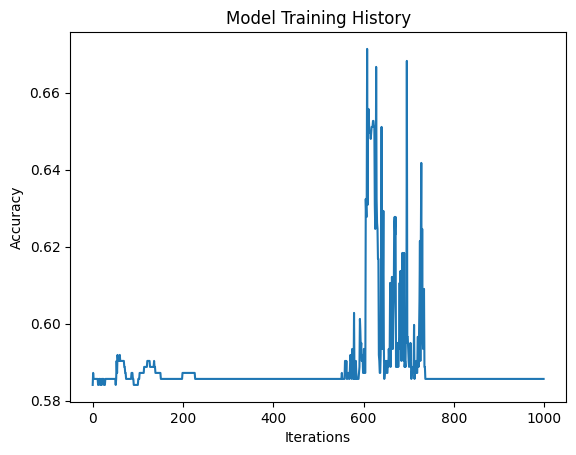

Self MLP accuracy: 0.6014492753623188
              precision    recall  f1-score   support

           0       0.53      0.93      0.68       123
           1       0.86      0.33      0.48       153

    accuracy                           0.60       276
   macro avg       0.70      0.63      0.58       276
weighted avg       0.72      0.60      0.57       276



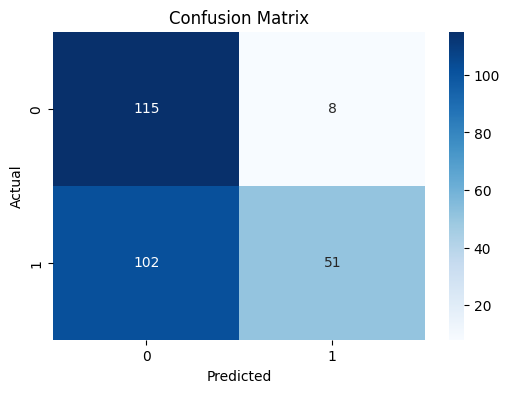

In [703]:
input_size = X_train.shape[1]
hidden_size = [10, 10]
output_size = y_train.shape[1]

mlp_custom = MultiLayerPerceptron(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.01, batch_size=16, iterations=1000)
history = mlp_custom.fit(X_train, y_train)

plt.plot(history['accuracy'])
plt.title('Model Training History')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

y_pred_probs = mlp_custom.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
print('Self MLP accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Accuracy: 0.8804347826086957

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       123
           1       0.88      0.90      0.89       153

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



c:\GitHub\MLM\.env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


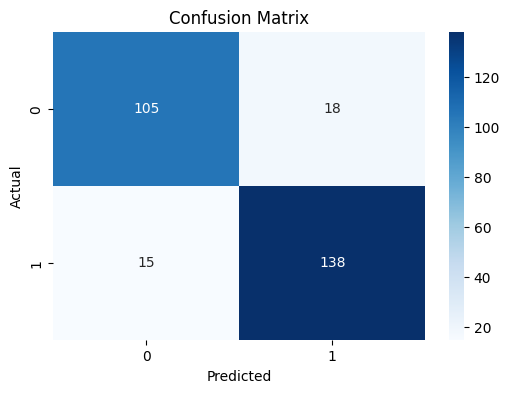

In [704]:
mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train.ravel())

y_pred_sklearn = mlp.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test, y_pred_sklearn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sklearn))

cm = confusion_matrix(y_test, y_pred_sklearn)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Аналіз результатів
1. Пояснити кожен рядок коду (за запитом викладача)
2. Вибір кількості шарів, обгрунтування архітектури
3. Оцінка помилок на начальній та тестовій вибірках
4. Результати оформити протоколом

In [705]:
results = pd.DataFrame({
'model': ['self_mlp', 'sklearn_mlp'],
'accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_sklearn)]
})
results

,model,accuracy
0,self_mlp,0.601449
1,sklearn_mlp,0.880435


# Контрольні питання
1. **Що таке MLP?**

    MLP (Multi-Layer Perceptron) — це клас штучних нейронних мереж повного зв'язку, що складаються з вхідного шару, одного або більше прихованих шарів і вихідного шару. Кожний нейрон виконує лінійну комбінацію вхідних значень з вагами + зсув, потім застосовує нелінійну функцію активації. MLP навчається методом зворотного розповсюдження з оптимізатором.

2. **Яке призначення прихованого шару?**

    Прихований шар дозволяє мережі вивчати нелінійні відношення між входом і виходом. Лінійна модель може апроксимувати лише лінійні функції; додавання прихованих шарів і нелінійних активацій дозволяє моделі будувати більш складні, багаторівневі представлення, що значно розширює клас функцій, які мережа може навчитися апроксимувати.